<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Qiskit_Transverse%20field%20Ising%20model%20to%20demo%20primitives_mkbahk_20241015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%pip install qiskit[visualization]=='1.2.4'
%pip install qiskit_ibm_runtime=='0.30.0'
%pip install qiskit_aer=='0.15.1'

In [11]:
%pip show qiskit qiskit_ibm_runtime qiskit_aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime
---
Name: qiskit-ibm-runtime
Version: 0.30.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: ibm-platform-services, numpy, pydantic, python-dateutil, qiskit, requests, requests-ntlm, urllib3, websocket-client
Required-by: 
---
Name: qiskit-aer
Version: 0.15.1
Summary: Aer - High performance simulators for 

In [12]:
%pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.16
albumentations                     1.4.15
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.19.0
astropy                            6.1.4
astropy-iers-data                  0.2024.10.7.0.32.46
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread        

In [13]:
import qiskit
qiskit.__version__

'1.2.4'

In [14]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.__version__

'0.30.0'

In [15]:
import qiskit_aer
qiskit_aer.__version__

'0.15.1'

# Transverse field Ising model to demo primitives

In [30]:
#아래 circuit은 estimator primitive를 위한 것

from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label="$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label="$\sqrt{Y}^\dagger$")

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits, trotter_barriers = False, layer_barriers = False):
  if num_cl_bits == 0:
    qc = QuantumCircuit(num_qubits)
  else:
    qc = QuantumCircuit(num_qubits, num_cl_bits)
  ###if

  for trotter_step in range(num_trotter_steps):
    add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if trotter_barriers:
      qc.barrier()
    ###if
  ###for

  return qc
###def

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
  # Adding Rzz in the even layers
  for i in range(0, qc.num_qubits - 1, 2):
    qc.sdg([i, i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the even layers
  for i in range(1, qc.num_qubits - 1, 2):
    qc.sdg([i, i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if

  qc.rx(rx_angle, list(range(qc.num_qubits)))

  if layer_barriers:
    qc.barrier()
  ###if
  return qc

###def



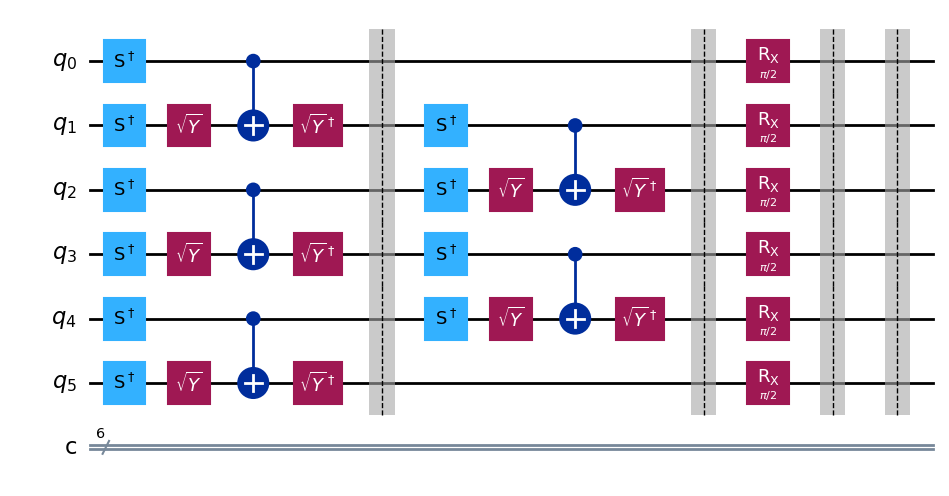

In [33]:
num_qubits = 6
#num_cl_bits = 6
num_trotter_steps = 1
rx_angle = np.pi/2

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold = -1)

# Demo Sampler

In [34]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

  for trotter_step in range(num_trotter_steps):
    add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if trotter_barriers:
      qc.barrier()
    ###if
  ###for

###def

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
  qc.rx(-rx_angle, list(range(qc.num_qubits)))

  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the odd layers
  for i in range(1, qc.num_qubits - 1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.s([i, i+1])
  ###for

  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the odd layers
  for i in range(0, qc.num_qubits - 1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.s([i, i+1])
  ###for

  if layer_barriers:
    qc.barrier()
  ###if

###def

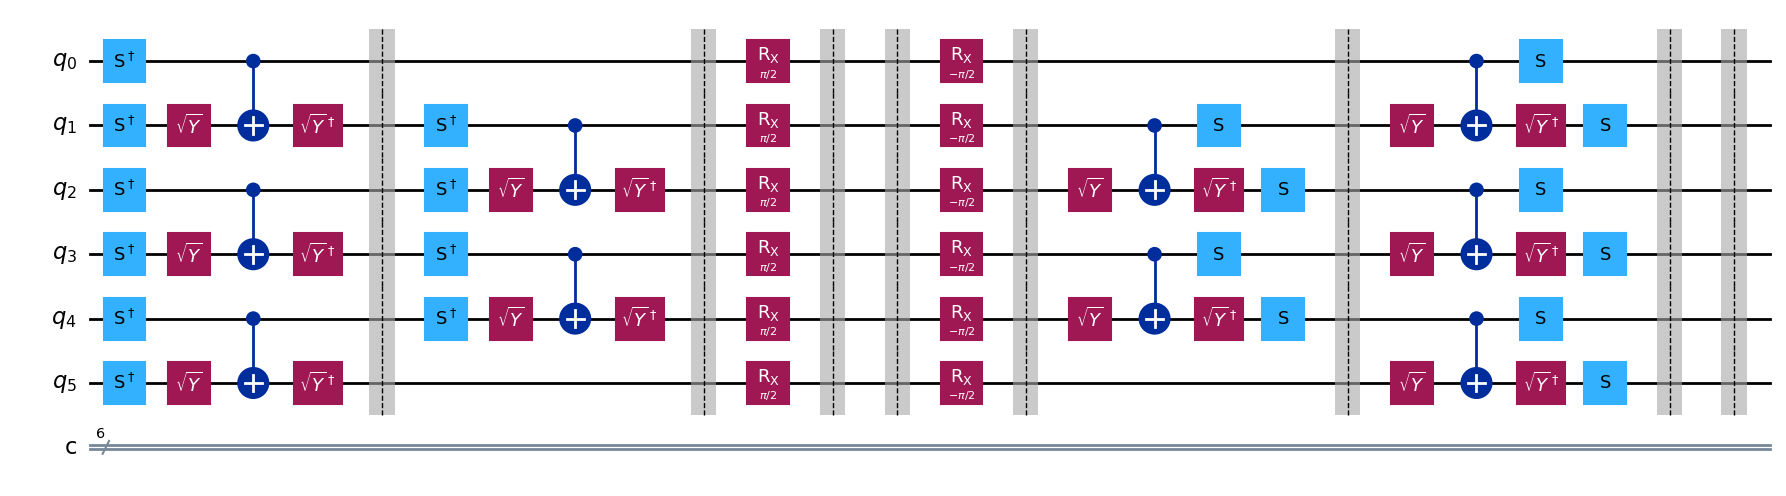

In [35]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold = -1)

# Step 1: Map the problem to circuit and observables

In [41]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_steps in range(max_trotter_steps):
  qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
  append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
  qc.measure(measured_qubits, [0, 1])
  qc_list.append(qc)
###for


In [ ]:
from qiskit_aer import Aer, AerSimulator, QasmSimulator, StatevectorSimulator, UnitarySimulator
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [ ]:
simulator = StatevectorSimulator()
#simulator = QasmSimulator()
#simulator = Aer.get_backend('aer_simulator_matrix_product_state')
#simulator = Aer.get_backend('statevector_simulator')
#simulator = Aer.backends(name='QasmSimulator')
#simulator = Aer.get_backend('qasm_simulator')

In [ ]:
from qiskit import transpile
qc_compiled = transpile(qc, simulator)

In [ ]:
# Execute the circuit and get the result
job = simulator.run(qc_compiled, shots=1024)
result = job.result()

In [ ]:
result

Result(backend_name='statevector_simulator', backend_version='0.15.1', qobj_id='', job_id='e17e095c-ab6c-4bd8-859e-0e911c642f02', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 508, '0x3': 516}, statevector=Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
            dims=(2, 2))), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=2, name='circuit-167', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=707739249, metadata={'time_taken': 0.015293437, 'num_bind_params': 1, 'parallel_state_update': 1, 'required_memory_mb': 1, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'statevector', 'device': 'CPU', 'num_qubits': 2, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'parallel_shots': 2, 'runtime_parameter_bind': False, 'max_memory_mb': 12978, 'noise': 'ideal', 'measure_sampling': False, 'batched_shots_optimization': False, 'result_typ

In [ ]:
result.backend_name

'statevector_simulator'

In [ ]:
result.results

[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 508, '0x3': 516}, statevector=Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
             dims=(2, 2))), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=2, name='circuit-167', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=707739249, metadata={'time_taken': 0.015293437, 'num_bind_params': 1, 'parallel_state_update': 1, 'required_memory_mb': 1, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'statevector', 'device': 'CPU', 'num_qubits': 2, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'parallel_shots': 2, 'runtime_parameter_bind': False, 'max_memory_mb': 12978, 'noise': 'ideal', 'measure_sampling': False, 'batched_shots_optimization': False, 'result_types': {'statevector': 'save_statevector'}, 'result_subtypes': {'statevector': 'single'}, 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold'

In [ ]:
result.results[0].data.counts

{'0x0': 508, '0x3': 516}

In [ ]:
counts = result.get_counts()
counts

{'00': 508, '11': 516}

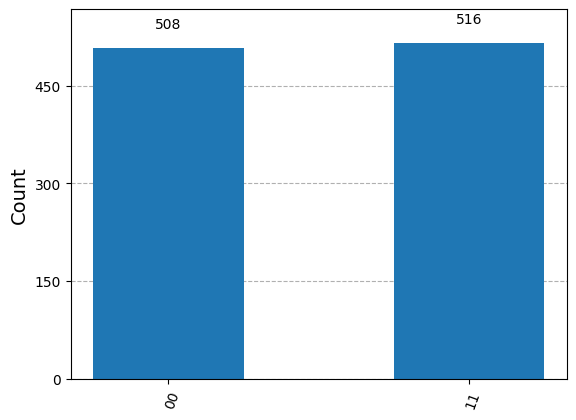

In [ ]:
from qiskit.visualization import plot_histogram # Import plot_histogram
plot_histogram(counts)

In [ ]:
statevector = result.get_statevector()

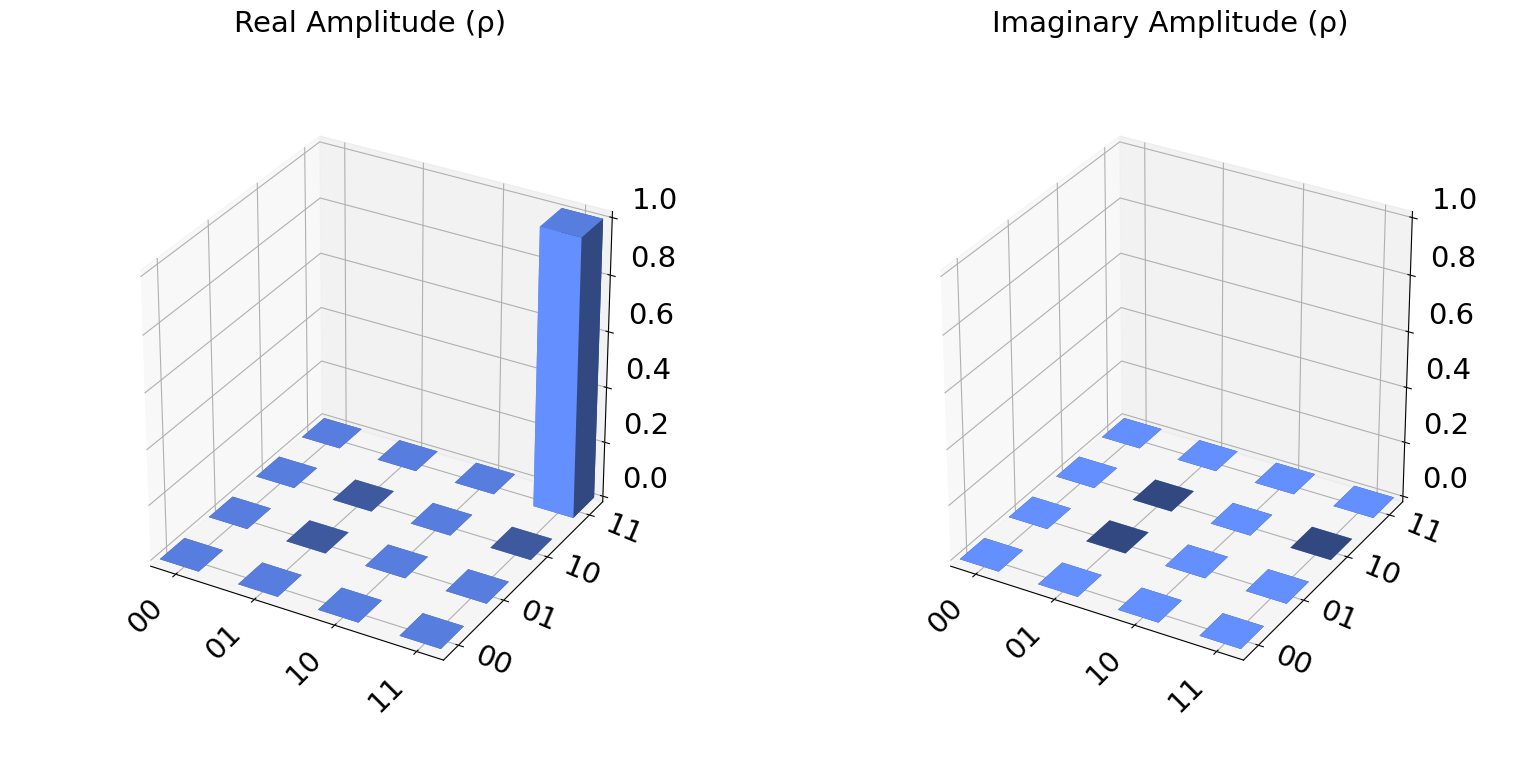

In [ ]:
from qiskit.visualization import plot_state_city
plot_state_city(statevector)